<a href="https://colab.research.google.com/github/22070049/Deep-Learning/blob/main/fake_news_cnn_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# 1. Load datasets
FAKE = "Fake.csv"
TRUE = "True.csv"

def choose_text_column(df):
    for col in ['text', 'content', 'title', 'headline', 'article']:
        if col in df.columns:
            return col
    for col in df.columns:
        if df[col].dtype == object:
            return col
    return None

df_fake = pd.read_csv(FAKE)
df_true = pd.read_csv(TRUE)
col_f = choose_text_column(df_fake)
col_t = choose_text_column(df_true)
df_fake = df_fake[[col_f]].copy(); df_fake['label'] = 0; df_fake.columns = ['text','label']
df_true = df_true[[col_t]].copy(); df_true['label'] = 1; df_true.columns = ['text','label']
df = pd.concat([df_fake, df_true], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
# 2. Clean text
def clean_text(s):
    if not isinstance(s,str):
        return ""
    s = s.lower()
    s = re.sub(r"http\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text)

In [5]:
# 3. Tokenization and padding
MAX_NUM_WORDS = 50000
MAX_SEQUENCE_LENGTH = 300
EMBED_DIM = 128

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_clean'])
sequences = tokenizer.texts_to_sequences(df['text_clean'])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y = df['label'].values

In [6]:
# 4. Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

In [7]:
# 5. Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
cw = {int(c): w for c, w in zip(classes, class_weights)}

In [8]:
# 6. Build CNN + RNN model
model = Sequential([
    Embedding(input_dim=min(MAX_NUM_WORDS, len(tokenizer.word_index)+1), output_dim=EMBED_DIM),
    SpatialDropout1D(0.2),
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 7. Train model
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mc = ModelCheckpoint('best_cnn_rnn.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, class_weight=cw, callbacks=[es, mc], verbose=1)

Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8925 - loss: 0.2048

269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.8928 - loss: 0.2043 - val_accuracy: 0.9990 - val_loss: 0.0048
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9971 - val_loss: 0.0080
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9992 - val_loss: 0.0054
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9998 - loss: 6.5231e-04 - val_accuracy: 0.9974 - val_loss: 0.0108


In [10]:
# 8. Evaluate
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9991091314031181
Precision: 0.9993771410775459
Recall: 0.998755057578587
F1: 0.99906600249066

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3522
           1       1.00      1.00      1.00      3213

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735


Confusion matrix:
 [[3520    2]
 [   4 3209]]


In [13]:
# 9. Save model and tokenizer
import json
with open("tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())
print("Saved best model to best_cnn_rnn.h5 and tokenizer.json")


Saved best model to best_cnn_rnn.h5 and tokenizer.json


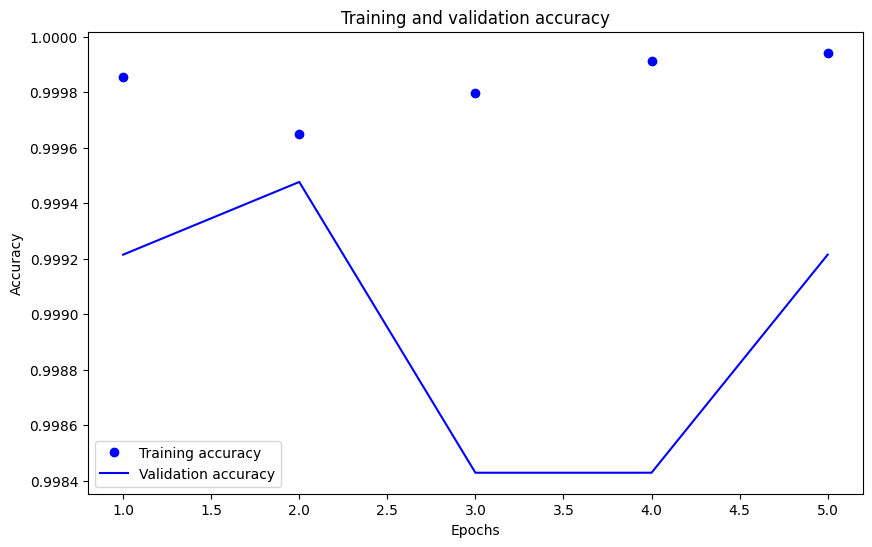

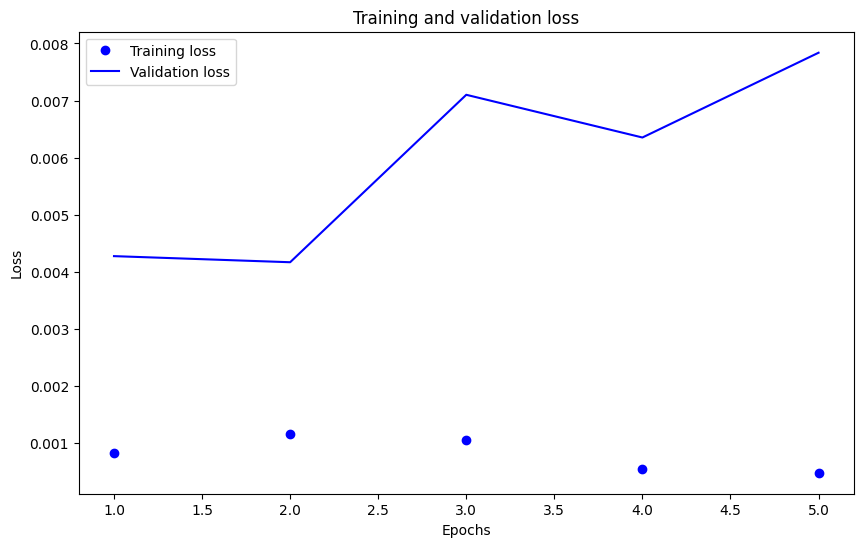

In [15]:
# 9. Visualize training history
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()